In [1]:
import pandas as pd
import numpy as np
import nltk
import os
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from nltk.corpus import treebank
import random
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
# reading in data
data_path = '/Users/christian_g/PycharmProjects/Data_Science_Projects/data/nlp/Therapy_chatbot.csv'
df = pd.read_csv(data_path)
df = df[['response_id', 'class', 'response_text']]

In [3]:
df.head()

,response_id,class,response_text
0,response_1,not_flagged,I try and avoid this sort of conflict
1,response_2,flagged,Had a friend open up to me about his mental ad...
2,response_3,flagged,I saved a girl from suicide once. She was goin...
3,response_4,not_flagged,i cant think of one really...i think i may hav...
4,response_5,not_flagged,Only really one friend who doesn't fit into th...


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80 entries, 0 to 79
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   response_id    80 non-null     object
 1   class          80 non-null     object
 2   response_text  80 non-null     object
dtypes: object(3)
memory usage: 2.0+ KB


In [5]:
# counting number of flagged vs not flagged
df['class'].value_counts()

class
not_flagged    55
flagged        25
Name: count, dtype: int64

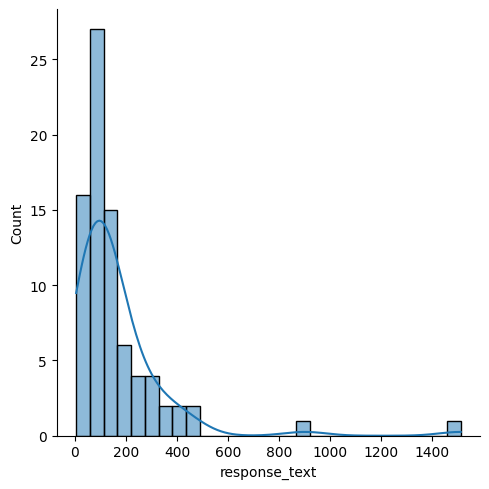

In [6]:
# analyzing response length
response_length = df.response_text.apply(lambda x: len(x))
sns.displot(response_length, kde=True)

In [7]:
df['response_length'] = response_length
df.response_length.describe()

count      80.000000
mean      162.587500
std       203.787907
min         5.000000
25%        66.250000
50%       108.500000
75%       186.000000
max      1512.000000
Name: response_length, dtype: float64

<Axes: xlabel='response_text', ylabel='class'>

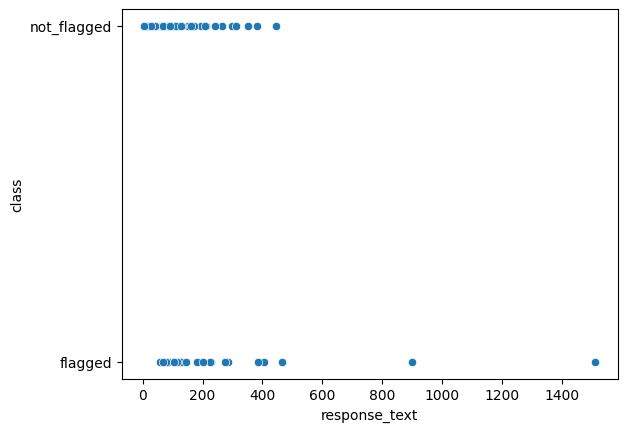

In [8]:
# analyzing relationship between response length and flag for therapy
sns.scatterplot(y = df['class'], x = response_length)

In [9]:
# analyzing average repsonse length for flagged vs not flagged
df.groupby('class').response_length.mean()

class
flagged        261.400000
not_flagged    117.672727
Name: response_length, dtype: float64

# playing with nltk

In [10]:
a = df.iloc[22].response_text
tokens = nltk.word_tokenize(a)
tokens[:5]

['Having', 'gone', 'through', 'depression', 'and']

In [11]:
tags = nltk.pos_tag(tokens[:5])
tags

[('Having', 'VBG'),
 ('gone', 'VBN'),
 ('through', 'IN'),
 ('depression', 'NN'),
 ('and', 'CC')]

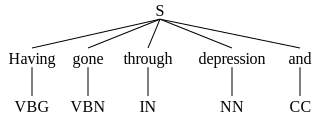

In [12]:
nltk.chunk.ne_chunk(tags)

In [13]:
all_words = []
for response in df.response_text:
    for word in response.split(' '):
        all_words.append(word.lower())
        
all_words = nltk.FreqDist(all_words)

In [14]:
all_words.most_common(10)

[('to', 104),
 ('i', 99),
 ('and', 84),
 ('a', 62),
 ('the', 50),
 ('of', 44),
 ('my', 41),
 ('was', 40),
 ('her', 37),
 ('with', 31)]

In [15]:
'the' in tokens

True

# SVC on Bag of Words

In [16]:
# vectorizing responses
vectorizer = CountVectorizer(ngram_range = (1, 2))
x_vectors = vectorizer.fit_transform(df.response_text).toarray()
len(x_vectors)

80

In [17]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_vectors, df['class'], test_size = 0.2)

In [18]:
from sklearn import svm

model = svm.SVC(kernel='linear')
model.fit(x_train, y_train)

SVC(kernel='linear')

In [19]:
# making predictions on test set
y_out = model.predict(x_test)
y_out

array(['flagged', 'not_flagged', 'not_flagged', 'not_flagged', 'flagged',
       'flagged', 'not_flagged', 'not_flagged', 'not_flagged',
       'not_flagged', 'flagged', 'flagged', 'not_flagged', 'not_flagged',
       'not_flagged', 'not_flagged'], dtype=object)

In [20]:
# for calculating model performance
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [21]:
accuracy_score(y_test, y_out)

0.6875

In [22]:
print(classification_report(y_test, y_out))

              precision    recall  f1-score   support

     flagged       0.40      0.50      0.44         4
 not_flagged       0.82      0.75      0.78        12

    accuracy                           0.69        16
   macro avg       0.61      0.62      0.61        16
weighted avg       0.71      0.69      0.70        16



In [23]:
# making prediction on new data 
new_input = vectorizer.transform(['I have mental health problems'])
model.predict(new_input.toarray())

array(['not_flagged'], dtype=object)

In [24]:
df['class'].value_counts()

class
not_flagged    55
flagged        25
Name: count, dtype: int64

# Word Vectors with spaCy (unweighted average classificaton)

In [25]:
import spacy

In [26]:
nlp = spacy.load("en_core_web_md")

In [27]:
doc = nlp("I am stupid")
doc

I am stupid

In [28]:
doc.vector[:10]

array([  1.98988   ,  -2.44638   ,  -0.81983995,  -7.7211995 ,
       -10.466567  ,   3.6552668 ,  -3.1364667 ,   5.6742616 ,
        -6.6615567 ,   8.3225565 ], dtype=float32)

In [29]:
len(doc.vector)

300

In [30]:
# verifying that full vector is just average of individual token vectors
all(sum([doc[i].vector for i in range(len(doc))]) / 3 == doc.vector)

True

In [31]:
# creating tokens for all responses
docs = [nlp(response) for response in df.response_text]

In [32]:
len(docs[1].vector)

300

In [33]:
# extracting list of vectors
x_vectors = [docs[i].vector for i in range(len(docs))]

In [34]:
# verifying word vectors were extracted correctly 
all(docs[23].vector == x_vectors[23])

True

In [35]:
# train test split, 80% train 20% test
x_train, x_test, y_train, y_test = train_test_split(x_vectors, df['class'], test_size = 0.2)

In [36]:
model = svm.SVC(kernel='linear')
model.fit(x_train, y_train)

SVC(kernel='linear')

In [37]:
# predicting test set
y_out = model.predict(x_test)

In [38]:
accuracy_score(y_test, y_out)

0.6875

In [39]:
print(classification_report(y_test, y_out))

              precision    recall  f1-score   support

     flagged       0.56      0.83      0.67         6
 not_flagged       0.86      0.60      0.71        10

    accuracy                           0.69        16
   macro avg       0.71      0.72      0.69        16
weighted avg       0.74      0.69      0.69        16



In [40]:
# making predictions on new text
new_text = ["I have depression and mental health problems", "happy", "I have mental health problems", "I have suicidal thoughts"]

In [41]:
model.predict([nlp(text).vector for text in new_text])

array(['not_flagged', 'not_flagged', 'not_flagged', 'flagged'],
      dtype=object)

In [42]:
# checking if embedding is the same regardless of word context
a = [nlp('I am going for a run'), nlp('I run the store')]

# 'run' has 2 very different meanings in these two sentences

In [43]:
a[0][-1], a[1][1]

(run, run)

In [44]:
all(a[0][-1].vector == a[1][1].vector)

# but they have the same embedding

True

In [45]:
x_matrix = np.array(x_vectors)

In [46]:
x_matrix.shape

(80, 300)

In [47]:
# doing svd for no reason
x_svd = np.linalg.svd(x_matrix)
x_svd

SVDResult(U=array([[-0.11482353,  0.03261471, -0.07417613, ..., -0.00194198,
        -0.02789913,  0.00978081],
       [-0.12387172, -0.08542468, -0.02029873, ...,  0.00903221,
        -0.02496972, -0.06518879],
       [-0.11604518, -0.08564059,  0.08778924, ...,  0.01517396,
         0.00731607,  0.08393703],
       ...,
       [-0.10613956, -0.07626843,  0.05123626, ..., -0.00606763,
         0.05117119,  0.02839063],
       [-0.11540174, -0.07738809,  0.01351839, ..., -0.06746227,
        -0.13575827, -0.12529464],
       [-0.11827701,  0.03981752, -0.0551338 , ..., -0.14582664,
         0.02840666,  0.02458952]], dtype=float32), S=array([280.86267  ,  73.08277  ,  51.340874 ,  48.620014 ,  41.38646  ,
        40.70942  ,  34.302105 ,  31.303701 ,  30.516596 ,  29.10774  ,
        26.429745 ,  24.438486 ,  23.858934 ,  22.944077 ,  19.870195 ,
        18.287874 ,  16.898335 ,  16.459215 ,  16.018436 ,  15.107336 ,
        14.56468  ,  14.341462 ,  13.749796 ,  13.288238 ,  13.139265

# Regexes

In [48]:
import re

In [49]:
pattern = r'^h[^a]*e$'

In [50]:
texts = ['house', 'houses', 'the house', 'home', 'homie', 'hai', 'hes']

In [51]:
for text in texts:
    if re.match(pattern, text):
        print(text)

house
home
homie


In [52]:
for text in texts:
    if re.search(pattern, text):
        print(text)

house
home
homie


# Stemming and Lemmatization with NLTK

In [53]:
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

stemmer = PorterStemmer()

In [54]:
# have to tokenize before stemming because need single words / tokens
text = 'I am going to run around a tiny amount of tracks better than you'
text_tokens = word_tokenize(text)
' '.join([stemmer.stem(token) for token in text_tokens])

'i am go to run around a tini amount of track better than you'

In [55]:
# now lemmatization
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

' '.join([lemmatizer.lemmatize(token, pos='a') for token in text_tokens])

'I am going to run around a tiny amount of tracks good than you'

!!! Important: to lemmatize properly, you need the POS. However, nltk by default just assumes everything is a noun

In [56]:
# pos = part of speech

[' '.join([lemmatizer.lemmatize(token, pos='n') for token in text_tokens]),
' '.join([lemmatizer.lemmatize(token, pos='v') for token in text_tokens]),
' '.join([lemmatizer.lemmatize(token, pos='a') for token in text_tokens]),
' '.join([lemmatizer.lemmatize(token, pos='r') for token in text_tokens]), 
' '.join([lemmatizer.lemmatize(token, pos='s') for token in text_tokens])]

['I am going to run around a tiny amount of track better than you',
 'I be go to run around a tiny amount of track better than you',
 'I am going to run around a tiny amount of tracks good than you',
 'I am going to run around a tiny amount of tracks well than you',
 'I am going to run around a tiny amount of tracks good than you']

# Removing Stopwords

Stopwords are just really common english words like 'it' or 'this' that don't really add meaning so it's helpful to remove them

In [57]:
from nltk.corpus import stopwords

In [58]:
stop_words = stopwords.words('english')
stop_words

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [59]:
len(stop_words)

179

In [60]:
text

'I am going to run around a tiny amount of tracks better than you'

In [61]:
' '.join([token for token in text_tokens if token not in stop_words])

'I going run around tiny amount tracks better'

## svc without stopwords

In [62]:
# TODO try and model without stopwords and compare

In [63]:
responses_no_stopwords = df['response_text'].apply(lambda x: ' '.join([word for word in word_tokenize(x) if word not in stop_words]))

In [64]:
responses_no_stopwords[:5]

0                            I try avoid sort conflict
1    Had friend open mental addiction weed taking l...
2    I saved girl suicide . She going swallow bunch...
3       cant think one really ... think may indirectly
4    Only really one friend n't fit categories . He...
Name: response_text, dtype: object

In [65]:
docs = [nlp(response) for response in responses_no_stopwords]

In [66]:
len(docs), len(docs[1].vector)

(80, 300)

In [67]:
x_vectors = np.array([doc.vector for doc in docs])

In [68]:
y = np.array(df['class'])

In [69]:
x_train, x_test, y_train, y_test = train_test_split(x_vectors, y, test_size = 0.2)

In [70]:
model = svm.SVC(kernel='linear')

In [71]:
model.fit(x_train, y_train)

SVC(kernel='linear')

In [72]:
y_out = model.predict(x_test)

In [73]:
print(classification_report(y_out, y_test))

              precision    recall  f1-score   support

     flagged       1.00      0.40      0.57        10
 not_flagged       0.50      1.00      0.67         6

    accuracy                           0.62        16
   macro avg       0.75      0.70      0.62        16
weighted avg       0.81      0.62      0.61        16



In [74]:
accuracy_score(y_test, y_out)

0.625

# Textblob

In [75]:
from textblob import TextBlob

In [76]:
blobs = [TextBlob(response) for response in df.response_text]

In [77]:
blobs[1]

TextBlob("Had a friend open up to me about his mental addiction to weed and how it was taking over his life and making him depressed")

In [78]:
a_blob = blobs[23]
a_blob.tags

[('Sometimes', 'RB'),
 ('my', 'PRP$'),
 ('friends', 'NNS'),
 ('bring', 'VBP'),
 ('up', 'RP'),
 ('issues', 'NNS'),
 ('they', 'PRP'),
 ('are', 'VBP'),
 ('having', 'VBG'),
 ('with', 'IN'),
 ('themselves', 'PRP'),
 ('and', 'CC'),
 ('I', 'PRP'),
 ('feel', 'VBP'),
 ('that', 'IN'),
 ('I', 'PRP'),
 ('give', 'VBP'),
 ('them', 'PRP'),
 ('good', 'JJ'),
 ('advice', 'NN'),
 ('and', 'CC'),
 ('make', 'VB'),
 ('them', 'PRP'),
 ('feel', 'VB'),
 ('adequate', 'JJ'),
 ('and', 'CC'),
 ('normal', 'JJ'),
 ('I', 'PRP'),
 ('just', 'RB'),
 ('try', 'VB'),
 ('to', 'TO'),
 ('be', 'VB'),
 ('kind', 'NN'),
 ('and', 'CC'),
 ('helpful', 'NN'),
 ('and', 'CC'),
 ('honest', 'NN')]

In [79]:
a_blob.sentences

[Sentence("Sometimes my friends bring up issues they are having with themselves, and I feel that I give them good advice and make them feel adequate and normal."),
 Sentence("I just try to be kind and helpful and honest.")]

In [80]:
a_blob.noun_phrases

WordList(['good advice'])

In [81]:
[sentence.sentiment for sentence in a_blob.sentences]

[Sentiment(polarity=0.3944444444444444, subjectivity=0.5277777777777778),
 Sentiment(polarity=0.6, subjectivity=0.9)]

In [82]:
a_blob.sentiment_assessments.assessments

[(['good'], 0.7, 0.6000000000000001, None),
 (['adequate'], 0.3333333333333333, 0.3333333333333333, None),
 (['normal'], 0.15, 0.6499999999999999, None),
 (['kind'], 0.6, 0.9, None),
 (['honest'], 0.6, 0.9, None)]

In [83]:
df['polarity'] = [blob.sentiment_assessments.polarity for blob in blobs]

In [84]:
df.head()

,response_id,class,response_text,response_length,polarity
0,response_1,not_flagged,I try and avoid this sort of conflict,37,0.000000
1,response_2,flagged,Had a friend open up to me about his mental ad...,122,-0.050000
2,response_3,flagged,I saved a girl from suicide once. She was goin...,130,0.495000
3,response_4,not_flagged,i cant think of one really...i think i may hav...,58,0.000000
4,response_5,not_flagged,Only really one friend who doesn't fit into th...,381,0.036364


In [85]:
df.polarity.describe()

count    80.000000
mean      0.050507
std       0.218682
min      -0.700000
25%       0.000000
50%       0.000000
75%       0.166667
max       0.500000
Name: polarity, dtype: float64

In [86]:
df.groupby('class').polarity.describe()

,count,mean,std,min,25%,50%,75%,max
class,,,,,,,,
flagged,25.0,0.092821,0.212481,-0.25,0.0,0.063333,0.190000,0.5
not_flagged,55.0,0.031274,0.220659,-0.70,0.0,0.000000,0.095833,0.5


In [87]:
# spell correction
a_blob.correct()

TextBlob("Sometimes my friends bring up issues they are having with themselves, and I feel that I give them good advice and make them feel adequate and normal. I just try to be kind and helpful and honest.")

In [88]:
a_blob.raw

'Sometimes my friends bring up issues they are having with themselves, and I feel that I give them good advice and make them feel adequate and normal. I just try to be kind and helpful and honest.'

In [89]:
# spell correction
b_blob = TextBlob('you ae the smartest person ever, i love yu')
b_blob.correct()

TextBlob("you a the smartest person ever, i love you")

In [90]:
b_blob.sentiment

Sentiment(polarity=0.5, subjectivity=0.6)

In [91]:
# seeing if there are any spelling errors
df['response_corrected'] = df.response_text.apply(lambda x: TextBlob(x).correct().raw)

In [92]:
df.head()

,response_id,class,response_text,response_length,polarity,response_corrected
0,response_1,not_flagged,I try and avoid this sort of conflict,37,0.000000,I try and avoid this sort of conflict
1,response_2,flagged,Had a friend open up to me about his mental ad...,122,-0.050000,Had a friend open up to me about his mental ad...
2,response_3,flagged,I saved a girl from suicide once. She was goin...,130,0.495000,I saved a girl from suicide once. The was goin...
3,response_4,not_flagged,i cant think of one really...i think i may hav...,58,0.000000,i can think of one really...i think i may have...
4,response_5,not_flagged,Only really one friend who doesn't fit into th...,381,0.036364,Only really one friend who doesn't fit into th...


In [93]:
# seeing what the correction does
df.iloc[2].response_text, df.iloc[2].response_corrected

# looks like it doesn't actually work that well. should not have corrected 'she' to 'the'

('I saved a girl from suicide once. She was going to swallow a bunch of pills and I talked her out of it in a very calm, loving way.',
 'I saved a girl from suicide once. The was going to swallow a bunch of pills and I talked her out of it in a very calm, loving way.')

In [94]:
a_blob.tags

[('Sometimes', 'RB'),
 ('my', 'PRP$'),
 ('friends', 'NNS'),
 ('bring', 'VBP'),
 ('up', 'RP'),
 ('issues', 'NNS'),
 ('they', 'PRP'),
 ('are', 'VBP'),
 ('having', 'VBG'),
 ('with', 'IN'),
 ('themselves', 'PRP'),
 ('and', 'CC'),
 ('I', 'PRP'),
 ('feel', 'VBP'),
 ('that', 'IN'),
 ('I', 'PRP'),
 ('give', 'VBP'),
 ('them', 'PRP'),
 ('good', 'JJ'),
 ('advice', 'NN'),
 ('and', 'CC'),
 ('make', 'VB'),
 ('them', 'PRP'),
 ('feel', 'VB'),
 ('adequate', 'JJ'),
 ('and', 'CC'),
 ('normal', 'JJ'),
 ('I', 'PRP'),
 ('just', 'RB'),
 ('try', 'VB'),
 ('to', 'TO'),
 ('be', 'VB'),
 ('kind', 'NN'),
 ('and', 'CC'),
 ('helpful', 'NN'),
 ('and', 'CC'),
 ('honest', 'NN')]

# Spacy-Transformers

In [95]:
# to download transformer

# !python -m spacy download en_core_web_trf

In [112]:
import spacy_transformers

In [117]:
nlp = spacy.load("en_core_web_trf")

In [121]:
doc = nlp('whats up what are you doing')

In [134]:
doc._.trf_data.all_outputs[0].data

array([[ 1.1977885 , -0.25394186,  0.56597584, ..., -0.08602735,
        -0.8119074 ,  0.68761855],
       [ 1.1624229 , -0.17774239, -0.5635356 , ..., -0.9541949 ,
        -0.7497127 ,  1.3600227 ],
       [ 0.22882454, -1.4209305 , -0.6411032 , ..., -0.06646345,
         0.11422511,  0.8559456 ],
       ...,
       [-0.38459077, -0.62709534,  0.02148902, ..., -0.70618105,
         0.3778615 , -0.10881593],
       [-0.34641382,  0.6604578 , -1.0199108 , ..., -0.2963935 ,
         0.6845951 ,  0.27118635],
       [ 0.61844647, -0.14361078, -0.75099987, ..., -2.0231466 ,
         0.6190034 , -0.03879869]], dtype=float32)